# Informe de la Felicidad Mundial hasta el 2015

# Objetivo del Proyecto

"Hacer predicciones sobre la esperanza de vida de un país (bandas L/M/H) a partir de un conjunto de métricas para el país correspondiente".

## Construir y Evaluar un Modelo de Clasificación

En el presente notebook construiré modelos de clasificación usando los modelos de decision trees (árboles de decisión) y logistic regression (algoritmos de regresión logística) con el objetivo de elegir el que tenga mejor rendimiento.

## Importar Librerías

In [21]:
# Core libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot

# Sklearn processing

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Sklearn classification algorithms

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Sklearn classification model evaluation function

from sklearn.metrics import accuracy_score

# Convenience functions.  This can be found on the course github

from functions import *

## Cargar los Datos

Se consolidó la información del Banco Mundial, Gapminder y el Informe Mundial sobre la Felicidad. 

Seleccioné algunas de las características disponibles de estas fuentes, se hizo calidad de datos y se realizó la atribución de los datos para proporcionarlas medidas más recientes de cada país hasta 2015.

In [6]:
# Cargar el data set

dataset = pd.read_csv("world_data.csv")

## Inspeccionar los Datos

Identificar el número de características (columnas) y muestras (filas).

In [7]:
# Examinar la dimensión de la matriz

dataset.shape

(194, 17)

Visualizar la información con la que estoy tratando.

In [9]:
# Inspeccionar las primeras filas

dataset.head()

,country,happiness,income,lifeexp,sanitation,water,urbanpopulation,unemployment,literacy,inequality,murder,energy,childmortality,fertility,hiv,foodsupply,population
0,Afghanistan,3.982855,1750.0,57.9,39.2,63.0,11.0,NaN,39.0,NaN,NaN,NaN,73.2,4.80,5800.0,2090.0,33700000
1,Albania,4.606651,11000.0,77.6,97.7,91.4,NaN,6.090,96.8,29.0,2.30,808.0,14.0,1.71,NaN,3190.0,2920000
2,Argentina,6.697131,19100.0,76.5,94.8,99.6,43.1,0.856,97.9,41.4,4.65,2020.0,11.6,2.31,95000.0,3230.0,43400000
3,Armenia,4.348320,8180.0,75.4,91.6,98.9,36.7,7.110,99.6,32.4,1.12,1020.0,14.0,1.66,3600.0,2930.0,2920000
4,Australia,7.309061,43800.0,82.6,100.0,100.0,60.2,1.240,NaN,34.7,1.11,5480.0,3.8,1.86,22000.0,3280.0,23800000


Comprobar que los tipos de datos son sensatos para cada característica, es decir, no quiero que ninguna característica numérica se muestre como objet.

In [10]:
# Revisar el tipo de dato

dataset.dtypes

country             object
happiness          float64
income             float64
lifeexp            float64
sanitation         float64
water              float64
urbanpopulation    float64
unemployment       float64
literacy           float64
inequality         float64
murder             float64
energy             float64
childmortality     float64
fertility          float64
hiv                float64
foodsupply         float64
population           int64
dtype: object

Registros nulos.

In [15]:
# Revisar si hay registros nulos

dataset.isnull().mean().sort_values()

country           0.000000
sanitation        0.000000
water             0.000000
population        0.000000
income            0.005155
childmortality    0.005155
lifeexp           0.036082
fertility         0.051546
energy            0.128866
foodsupply        0.134021
inequality        0.175258
literacy          0.231959
hiv               0.231959
happiness         0.278351
dtype: float64

## Limpieza de Datos

Algunas de estas características (asesinato, población urbana, desempleo) están muy poco pobladas. Si dejara los nulos, estaría estimando un gran número de valores por lo que voy a descartarlos por ahora.

In [13]:
# Discard very sparse features

dataset = dataset.drop(["murder","urbanpopulation","unemployment"], axis=1)

A las demás características sólo les asignaré el valor medio de la característica.  

In [16]:
# Calcular la media de cada característica

means = dataset.mean().to_dict()

# Asignar cada nulo con la media de esa característica

for m in means:
    dataset[m] = dataset[m].fillna(value=means[m])

Piensa en mi estrategia de limpieza en éste punt.  ¿Podría tomar un enfoque más sofisticado?

Confirmar que no tengo nulos luego de haber agregar la media de cada característica.

In [18]:
# Revisar si hay registros nulos

dataset.isnull().mean()

country           0.0
happiness         0.0
income            0.0
lifeexp           0.0
sanitation        0.0
water             0.0
literacy          0.0
inequality        0.0
energy            0.0
childmortality    0.0
fertility         0.0
hiv               0.0
foodsupply        0.0
population        0.0
dtype: float64

## Comprender los Datos

### Estadísticas descriptivas
Las estadísticas descriptivas dan una idea del rango y la extensión de los valores de cada característica y nos permite detectar patrones inesperados. 

In [19]:
# Procesar las estadísticas descriptivas

dataset.describe()

,happiness,income,lifeexp,sanitation,water,literacy,inequality,energy,childmortality,fertility,hiv,foodsupply,population
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,1.940000e+02,194.000000,1.940000e+02
mean,5.395765,17432.849741,71.933690,73.838247,86.329381,81.573826,38.579375,2183.725325,31.441451,2.835924,2.179917e+05,2845.952381,3.787195e+07
std,0.953547,19072.580021,7.466359,29.269367,17.568245,17.055722,7.257464,2618.536430,31.237992,1.336162,5.521169e+05,413.199619,1.419670e+08
min,2.701591,623.000000,49.600000,7.080000,19.300000,25.300000,16.600000,9.580000,2.200000,1.240000,6.000000e+01,1880.000000,1.100000e+04
25%,4.891838,3297.500000,66.425000,49.225000,77.900000,75.575000,34.000000,614.500000,8.200000,1.790000,1.025000e+04,2570.000000,1.982500e+06
50%,5.395765,11050.000000,72.550000,87.900000,94.950000,81.573826,38.579375,1565.000000,17.900000,2.415000,7.000000e+04,2845.952381,8.435000e+06
75%,5.880369,24100.000000,77.400000,97.700000,99.300000,95.375000,42.175000,2425.000000,49.225000,3.687500,2.179917e+05,3140.000000,2.742500e+07
max,7.603434,120000.000000,83.800000,100.000000,100.000000,100.000000,63.000000,18600.000000,137.000000,7.290000,5.600000e+06,3770.000000,1.400000e+09


### Matriz de Correlación

Se puede utilizar una matriz de correlación para detectar las correlaciones entre las características.  

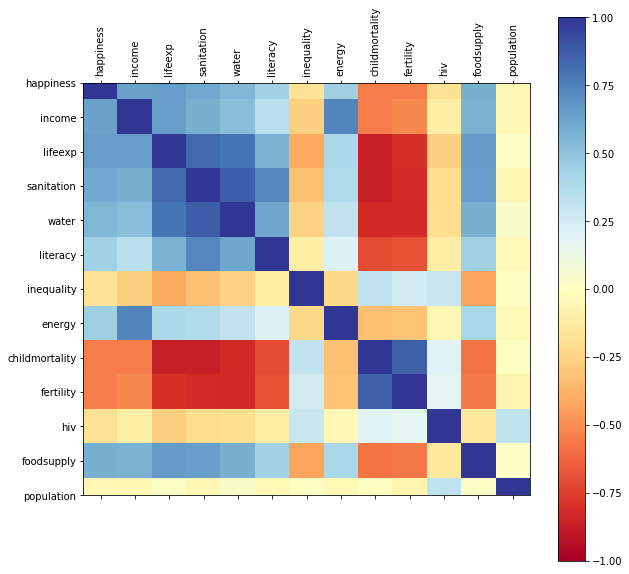

In [22]:
# Display a correlation matrix

correlationMatrix(dataset)

Trazar algunos boxplots para entender la distribución de cada característica.  

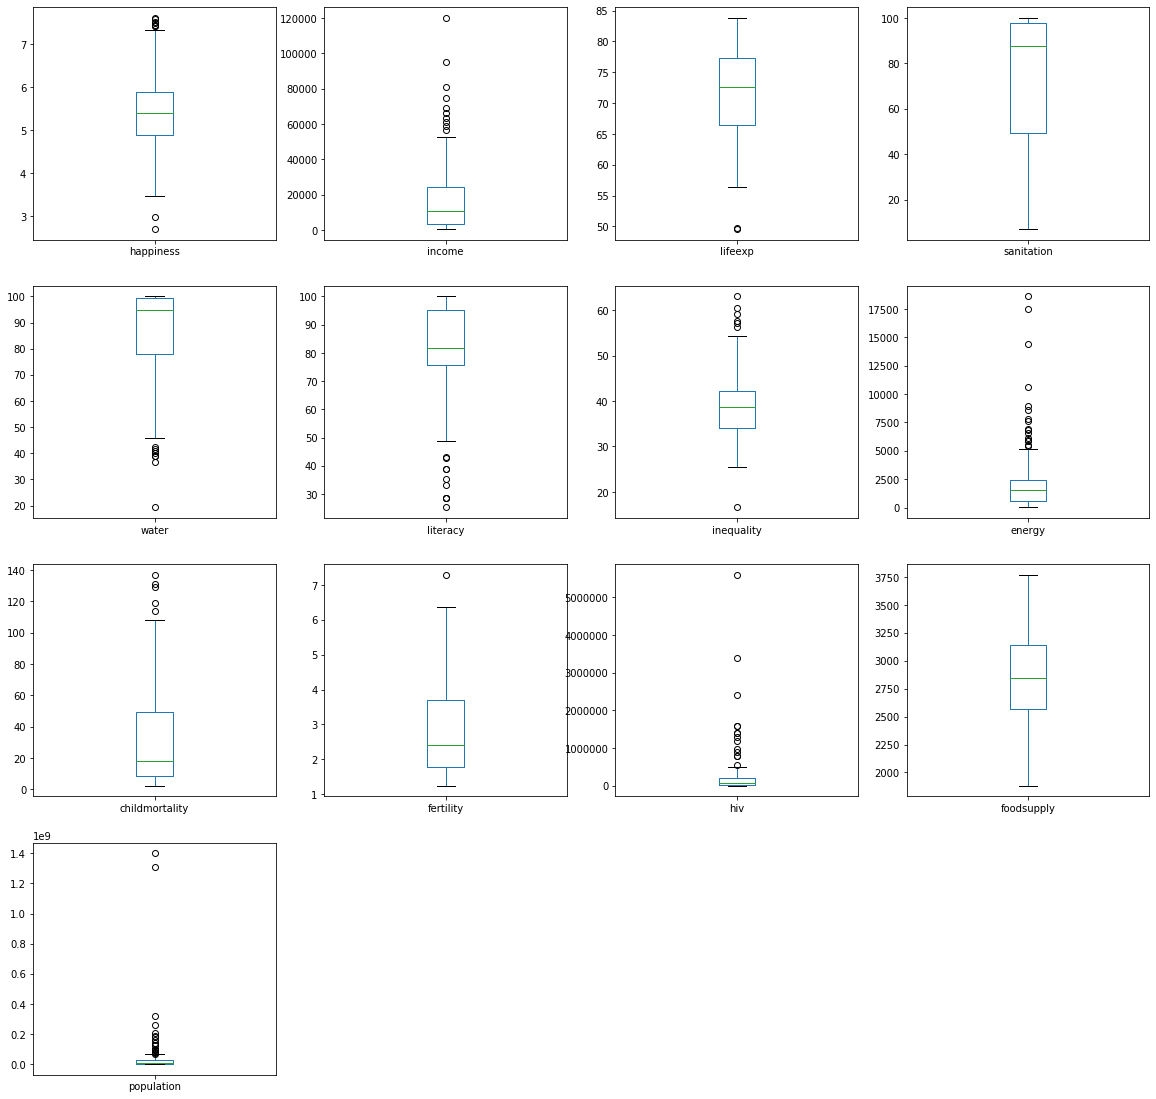

In [23]:
# Visualizar boxplots para cada característica numérica

boxPlotAll(dataset)

## Preparar los Datos
### Ingeniería de Características

Crear la característica "lifeexp", la cuál será la característica defina como target (destino).

In [24]:
# Bin lifexp en las bandas L, M y H

dataset = appendEqualCountsClass(dataset, "lifeexp_band", "lifeexp", 3, ["L","M","H"])

Comprobar que tenemos una distribución uniforme de las filas a través de las bandas.

In [25]:
# Comprobar cuántas filas hay en cada bin

dataset.lifeexp_band.value_counts()

H    65
L    65
M    64
Name: lifeexp_band, dtype: int64

Revisar unas cuantas filas están como se esperaba.

In [26]:
# Comprobar que el binning funciona como se esperaba

dataset[['lifeexp','lifeexp_band']].head()

,lifeexp,lifeexp_band
0,57.9,L
1,77.6,H
2,76.5,H
3,75.4,M
4,82.6,H


### Seleccionar las características dividiéndolas en características de entrada y de destino

Decidir cuales columnas usar como entrada y cuales como target (destino).  Recordemos las columnas que tenemos.

In [27]:
dataset.columns

Index(['country', 'happiness', 'income', 'lifeexp', 'sanitation', 'water',
       'literacy', 'inequality', 'energy', 'childmortality', 'fertility',
       'hiv', 'foodsupply', 'population', 'lifeexp_band'],
      dtype='object')

Seleccionar lifeexp_band como nuestra característica de destino (la que predecimos) y todo lo demás como las características de entrada (las que usaremos para hacer la predicción).

In [29]:
# Dividir en características de entrada y de destino

y = dataset["lifeexp_band"]
X = dataset[['happiness', 'income', 'sanitation', 'water', 'literacy', 'inequality', 'energy', 'childmortality', 'fertility',  'hiv', 'foodsupply', 'population']]

In [30]:
X.head()

,happiness,income,sanitation,water,literacy,inequality,energy,childmortality,fertility,hiv,foodsupply,population
0,3.982855,1750.0,39.2,63.0,39.000000,38.579375,2183.725325,73.2,4.80,5800.000000,2090.0,33700000
1,4.606651,11000.0,97.7,91.4,96.800000,29.000000,808.000000,14.0,1.71,217991.677852,3190.0,2920000
2,6.697131,19100.0,94.8,99.6,97.900000,41.400000,2020.000000,11.6,2.31,95000.000000,3230.0,43400000
3,4.348320,8180.0,91.6,98.9,99.600000,32.400000,1020.000000,14.0,1.66,3600.000000,2930.0,2920000
4,7.309061,43800.0,100.0,100.0,81.573826,34.700000,5480.000000,3.8,1.86,22000.000000,3280.0,23800000


In [31]:
y.head()

0    L
1    H
2    H
3    M
4    H
Name: lifeexp_band, dtype: category
Categories (3, object): [L < M < H]

### Características de Escala

Cuando ejecuté dataset.describe el rango de valores entre el mínimo y el máximo era diferente para las diferentes características.

In [32]:
X.describe()

,happiness,income,sanitation,water,literacy,inequality,energy,childmortality,fertility,hiv,foodsupply,population
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,1.940000e+02,194.000000,1.940000e+02
mean,5.395765,17432.849741,73.838247,86.329381,81.573826,38.579375,2183.725325,31.441451,2.835924,2.179917e+05,2845.952381,3.787195e+07
std,0.953547,19072.580021,29.269367,17.568245,17.055722,7.257464,2618.536430,31.237992,1.336162,5.521169e+05,413.199619,1.419670e+08
min,2.701591,623.000000,7.080000,19.300000,25.300000,16.600000,9.580000,2.200000,1.240000,6.000000e+01,1880.000000,1.100000e+04
25%,4.891838,3297.500000,49.225000,77.900000,75.575000,34.000000,614.500000,8.200000,1.790000,1.025000e+04,2570.000000,1.982500e+06
50%,5.395765,11050.000000,87.900000,94.950000,81.573826,38.579375,1565.000000,17.900000,2.415000,7.000000e+04,2845.952381,8.435000e+06
75%,5.880369,24100.000000,97.700000,99.300000,95.375000,42.175000,2425.000000,49.225000,3.687500,2.179917e+05,3140.000000,2.742500e+07
max,7.603434,120000.000000,100.000000,100.000000,100.000000,63.000000,18600.000000,137.000000,7.290000,5.600000e+06,3770.000000,1.400000e+09


Muchos algoritmos no funcionarán al máximo cuando se les presenten tales datos, por lo que los escalaré para que todos estén en el rango de 0 a 1.

In [34]:
# Reescalar los datos

scaler = MinMaxScaler(feature_range=(0,1))
rescaledX = scaler.fit_transform(X)

# Convertir X de nuevo en un DataFrame de Pandas por conveniencia

X = pd.DataFrame(rescaledX, columns=X.columns)

Ahora se puede ver que cada característica tiene un mínimo de 0 y un máximo de 1:.

In [35]:
X.describe()

,happiness,income,sanitation,water,literacy,inequality,energy,childmortality,fertility,hiv,foodsupply,population
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,0.549625,0.140813,0.718449,0.830600,0.753331,0.473693,0.116950,0.216925,0.263789,0.038917,0.511086,0.027044
std,0.194528,0.159768,0.314995,0.217698,0.228323,0.156411,0.140854,0.231736,0.220853,0.098593,0.218624,0.101406
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.446821,0.022404,0.453562,0.726146,0.673025,0.375000,0.032539,0.044510,0.090909,0.001820,0.365079,0.001408
50%,0.549625,0.087345,0.869780,0.937423,0.753331,0.473693,0.083668,0.116469,0.194215,0.012489,0.511086,0.006017
75%,0.648486,0.196663,0.975248,0.991326,0.938086,0.551185,0.129928,0.348850,0.404545,0.038917,0.666667,0.019582
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Modelos de Construcción
Construir modelos tanto decision trees como logistic regression y para definir cual tiene un mejor rendimiento.


### Dividir en Conjuntos de Prueba y Entrenamiento
Dividir los conjuntos X e Y en conjuntos de entrenamiento y de prueba.

In [36]:
# Dividir en sets de prueba y entrenamiento

test_size = 0.33
seed = 1
X_train, X_test, Y_train, Y_test =  train_test_split(X, y, test_size=test_size, random_state=seed)

### Crear Múltiples Modelos y Ajustarlos
Construir modelos y ajustarlos (fit) con los datos de entrenamiento.

In [37]:
# Construir un modelo de decision tree

model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [38]:
# Construir un modelo de logistic regression

model_lr = LogisticRegression(solver='lbfgs', multi_class='auto')
model_lr.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Revisar los Modelos

Pasar los datos de entrenamiento a través de ambos modelos y para validar el rendimiento de los mismos.

In [39]:
# Verificar el rendimiento del modelo con los datos de entrenamiento

predictions_dt = model_dt.predict(X_train)
print("DecisionTreeClassifier", accuracy_score(Y_train, predictions_dt))

DecisionTreeClassifier 1.0


In [40]:
# Compruebe el rendimiento del modelo logistic regression con los datos de entrenamiento

predictions_lr = model_lr.predict(X_train)
print("LogisticRegression", accuracy_score(Y_train, predictions_lr))

LogisticRegression 0.8217054263565892


## Evaluar los Modelos
Evaludar los modelos probándolos con el set de pruebas.

In [41]:
predictions_dt = model_dt.predict(X_test)
print("DecisionTreeClassifier", accuracy_score(Y_test, predictions_dt))

DecisionTreeClassifier 0.676923076923077


In [42]:
predictions_lr = model_lr.predict(X_test)
print("LogisticRegression", accuracy_score(Y_test, predictions_lr))

LogisticRegression 0.7230769230769231


### Elegir el Modelo con Mejor Rendimiento
El modelo logistic regression será el modelo elegido ya que fue el que tuvo mejor rendimiento.

In [43]:
model = model_lr

## Inspeccionar los Modelos
Aquí está el árbol de decisiones creado para el presente proyecto.

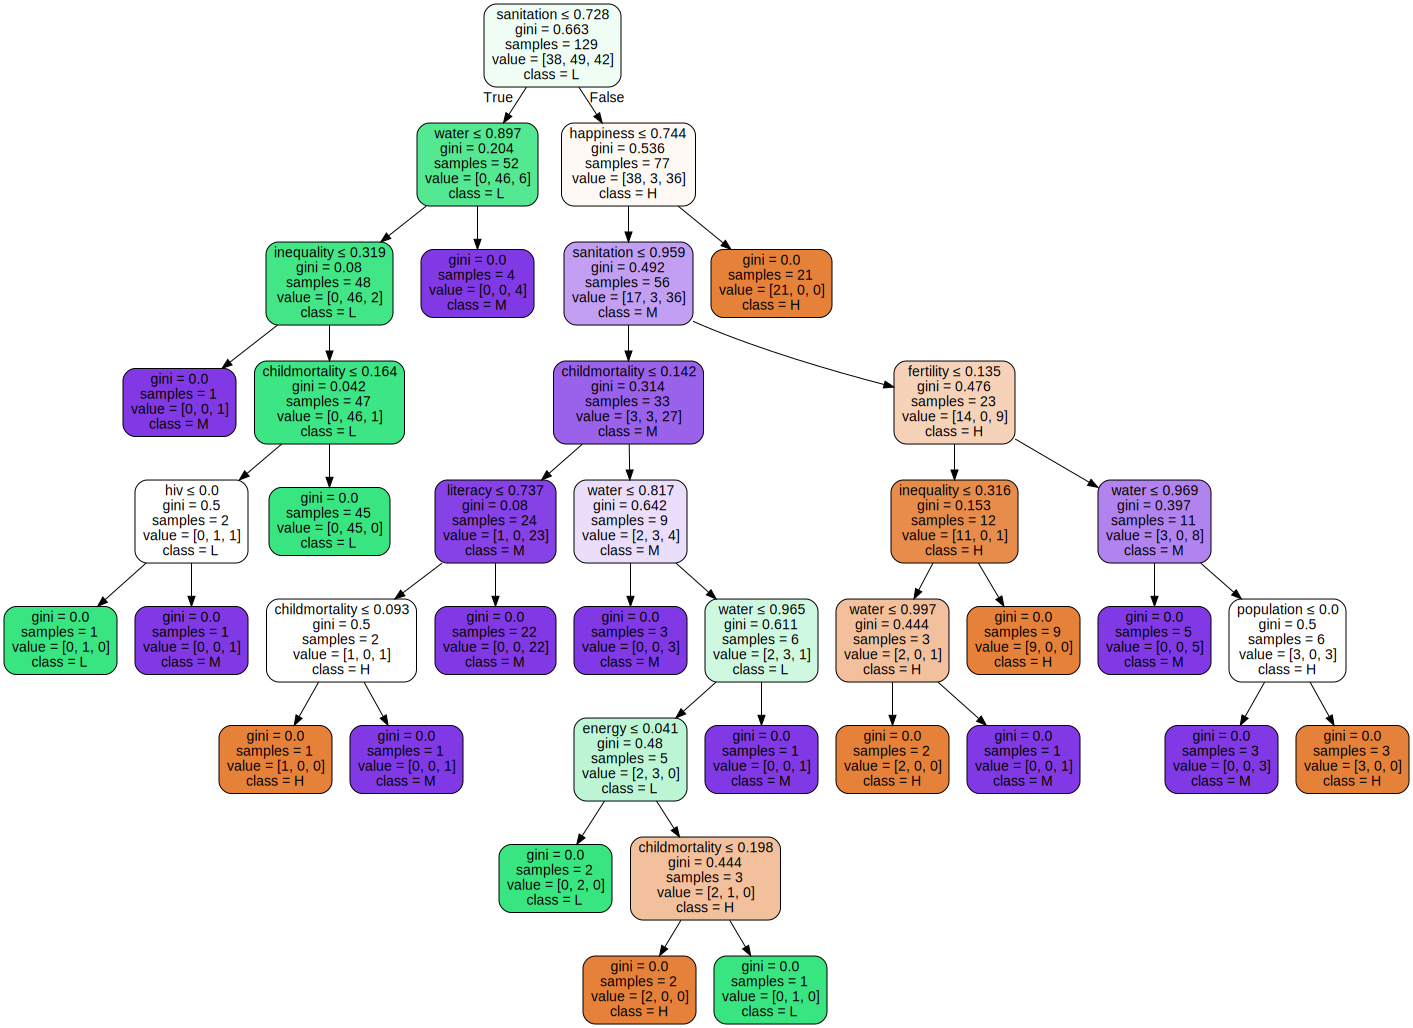

In [44]:
viewDecisionTree(model_dt, X.columns)

Importancia de las características.

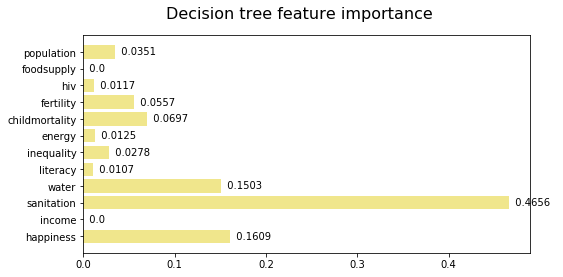

In [45]:
decisionTreeSummary(model_dt, X.columns)

Examinar los coeficientes del modelo logistic regression.

In [48]:
model_lr.classes_

array(['H', 'L', 'M'], dtype=object)

In [49]:
model_lr.coef_

array([[ 1.56109512,  1.43854829,  1.21032309,  0.71015589,  0.16496136,
        -0.21151471,  0.38168319, -0.90984066, -0.7007721 , -0.06693589,
         1.35850726, -0.26528544],
       [-1.04391607, -0.40989364, -1.85609818, -1.39903662, -0.71497946,
         0.2072231 , -0.15851575,  1.53414928,  1.15354453,  0.24971128,
        -0.74221789,  0.09642796],
       [-0.51717906, -1.02865465,  0.64577509,  0.68888074,  0.5500181 ,
         0.00429161, -0.22316744, -0.62430862, -0.45277243, -0.18277539,
        -0.61628937,  0.16885748]])

Plot de los coeficientes del modelo logistic regression.

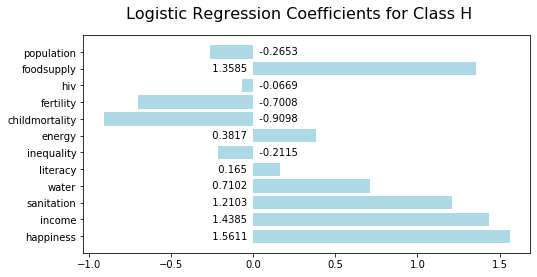

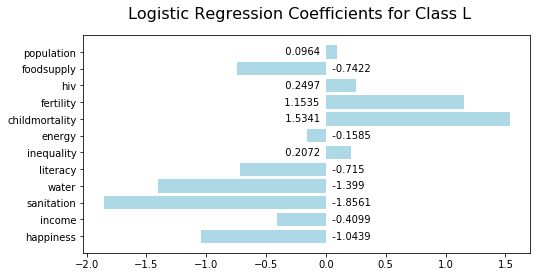

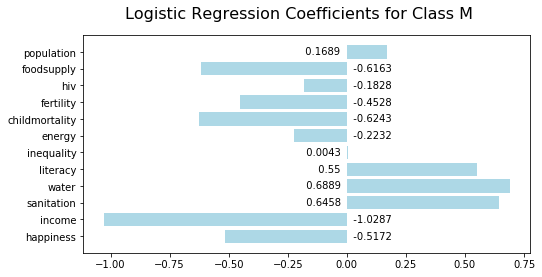

In [50]:
logisticRegressionSummary(model_lr, X.columns)